# 로봇항공기 대회 개념설계 보완ver.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import math
import os

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

## 1. 날개류
- 주 날개의 형상과 위치 무게중심 등
- 꼬리날개의 배치와 안정성
- 주익 sd7062
- 미익 naca0012
- 주익과 미익으로 동체 없이 안정한 결과

In [2]:
def Oswald(AR):
    '''
    return Oswald's efficincy coefficient
    실험식을 통한 추정 직선익에서 활용
    -----------------------------------------
    AR : Aspect Ratio
    '''

    return 1.78*(1-0.045*AR**0.68)-0.64

def wing_area(V_stall, rho, CL_max, W_TO):
    '''
    return Wing Area
    최저 속도로 최대 양력계수일 때 이륙 총 중량을 띄울 수 있는 날개 면적
    -----------------------------------------
    V_stall : stall speed (m/s)
    rho : Air density (kg/m^3)
    CL_max : 최대 양력계수
    W_TO : 이륙 총 중량(kg)
    '''
    S = W_TO*9.81 / (0.5* rho* CL_max* (V_stall**2))

    return S

def kappa(AR):
    '''
    return kappa for C_D = C_D0 + kappa*C_L^2
    '''
    e = Oswald(AR)
    
    return 1/np.pi* AR* e

def chord_length(S, lamda, b, r=0.375):
    '''
    중심부터 span의 40%까지는 직선익 + 이후 tapered wing으로 주익을 구성
    tapered wing 부분의 root chord 와 tip chord
    -----------------------------------
    r : 주익대비 straight wing의 비율 37.5%
    C_r : root chord length
    C_t : tip chord length
    '''

    C_r = S/(2/3*b*(1-r)*(1+lamda+lamda**2)/(1+lamda) + r*b)
    C_t = C_r*lamda
    
    return C_r, C_t, r

def Vtail_wing(C_mean, S_wing, span_wing, L, c_ht, c_vt):
    '''
    부피계수와 arm의 길이로부터 V-tail의 Area와 Dihedral 각도 계산
    항공기 개념설계 식 참고
    -------------------------
    C_mean : mean aerodynamic chord of main wing
    S_wing : Main wing area
    span_wing : wing span of main wing = b
    L : arm length from Leading edge to tail leading edge
    C_ht : Horizon tail volume coefficient
    C_vt : Vertical tail volume coefficient
    '''

    S_ht = c_ht*C_mean*S_wing/L
    S_vt = c_vt*span_wing*S_wing/L
    # Dihedral 각도
    phi = np.arctan(S_vt/S_ht)
    # 꼬리날개 면적
    S_t = S_ht/np.cos(phi)

    return S_t, phi

def cg_move_tilt(W_TO, W_motor, d_move):
    '''
    틸트시 모터에 의해 무게중심이 이동한 거리를 반환한다.
    모멘트 평형식을 정리하여 반환
    -----------------------------------
    W_TO : 이륙 총 중량(kg)
    W_motor : 모터 한개 중량(g)
    d_move : 틸트시 모터의 무게중심 이동 거리(mm)
    '''
    return 2*W_motor/W_TO/1000*d_move

In [3]:
# 실속속도(m/s), 공기밀도(kg/m^3), 최대양력계수 SD7062, 이륙 총 중량(kg)
V_stall = 13
rho = 1.225
CL_max = 1.5
W_TO = 5

# 익면적 초기 사이징
S = wing_area(V_stall, rho, CL_max, W_TO)
print('Wing area : %fm^2' %S)

Wing area : 0.315904m^2


In [4]:
# 주익 형상 사이징
# AR = b/c = b^2/S 가로세로비, Aspect Ratio
# lamda = Taper Ratio

lamda = 0.8
AR = 9.4
b = np.sqrt(AR*S)
c_root, c_tip, r = chord_length(S, lamda, b)
print('Wind span length : %.2fmm' %(b*1000))
print('Wind span length/2 : %.2fmm\n' %(b*1000/2))
print('root chord length : %.2fmm' %(c_root*1000))
print('tip chord length : %.2fmm\n' %(c_tip*1000))
print('Straight wing ratio vs wing span : %.1f' %(r*100) + '%')
print('Straight wing span/2 :%.2fmm' %(b*r/2*1000))

Wind span length : 1723.22mm
Wind span length/2 : 861.61mm

root chord length : 195.06mm
tip chord length : 156.05mm

Straight wing ratio vs wing span : 37.5%
Straight wing span/2 :323.10mm


In [5]:
# mean aerodynamic chord of main wing
c_mean = b/AR

# tail wing distance : L
# volumetric coefficient
L = 0.6
c_ht = 0.8
c_vt = 0.06

S_tail, phi = Vtail_wing(c_mean, S, b, L, c_ht, c_vt)
AR_tail = 5

# span & mean chord
b_tail = np.sqrt(S_tail*AR_tail)
c_mean_tail = b_tail/AR_tail

# taper ratio of tail wing
lamda_tail = 0.6

c_root_tail = c_mean_tail/(2/3 * ((1+lamda_tail+lamda_tail**2)/(1+lamda_tail)))
c_tip_tail = c_root_tail * lamda_tail

print('Tail wing span length/2 : %.2fmm\n' %(b_tail*1000/2))
print('사영된 전체 스팬 길이 : %.2fmm\n' %(b_tail*1000*np.cos(phi)))
print('Tail root chord length : %.2fmm' %(c_root_tail*1000))
print('Tail tip chord length : %.2fmm\n' %(c_tip_tail*1000))
print('Dihedral angle : %.2fdegree' %(np.rad2deg(phi)))

Tail wing span length/2 : 343.65mm

사영된 전체 스팬 길이 : 561.73mm

Tail root chord length : 168.32mm
Tail tip chord length : 100.99mm

Dihedral angle : 35.18degree


In [6]:
# 모터 중량 (g)
w_motor = 140
# 틸트시 모터 무게중심 이동 거리 (mm)
d_move = 40

x= cg_move_tilt(W_TO, w_motor, d_move)
# Rotor wing시에 cg를 설정 = 86mm
cg_RW = 86
# Fixed wing 시 무게중심의 위치
cg_FW = cg_RW - x

print('FW center of gravity : %.1fmm' %cg_FW)

FW center of gravity : 83.8mm


- 주익 붙임각 2도, 미익 붙임각 1도
- cg = 84mm인 경우 트림(aoa=1.4)에서 좋은 양항비(22.65)와 양력계수 0.64정도로 매우 적절함(날개만)
- 틸트 서보모터의 작동으로 발생하는 모터 cg의 변화는 약 30mm, 초기 중량 4.5kg기준으로 모터의 중량을 고려하여 이륙시 cg는 약 86mm정도에 위치
- dcm/dcl이 음수이며 받음각 1~2사이에서 트림이 되며 그때 양력계수가 0.6근처정도면 잘된 설계다

## 2. 추진계통
- 종류나 갯수, 장착 위치 등 추력 계산
- 구조자 무게 고려

In [7]:
def wing_tip_speed(inch, RPM):
    '''
    프로펠러 인치와 RPM으로부터 wing tip의 속도(m/s)를 반환
    ----------------------
    inch : prop inch
    RPM : Reps per minute
    return : prop radius * Angular speed(=RPM/60*2pi) 
    '''
    return 0.0254*inch*RPM/60*2*np.pi

def interpolate(x_data, y_data, x_query):
    """
    선형 보간 함수 (scipy 사용)

    Parameters:
    - x_data: 기준 x 값들 (1D array-like)
    - y_data: 기준 y 값들 (1D array-like)
    - x_query: 보간할 x 값들 (스칼라 또는 배열)

    Returns:
    - 보간된 y 값들 (스칼라 또는 배열)
    """
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    x_query = np.atleast_1d(x_query)

    f = interp1d(x_data, y_data, kind='linear', fill_value='extrapolate')

    y_interp = f(x_query)

    return y_interp[0] if y_interp.size == 1 else y_interp


### 임무 소요 시간 결정

In [8]:
# 임무별 소요 시간(s)
time_RW = 200
time_TR = 20
time_FW = 180

# 전체 시간(h)
time_total = (time_RW + time_TR + time_FW)/3600

### Required Thrust

In [9]:
CL_cruise = 0.6
V_cruise = np.sqrt(2*W_TO*9.81/S/rho/CL_cruise)

CD_cruise = 0.05
Drag = 0.5*rho*V_cruise**2*S*CD_cruise

# 근데 이거는 바람 속도에 의한 추력 감소를 고려 안함
Thrust_FW = Drag/9.81*1000    # g단위
Thrust_RW = W_TO*1000/4
# 앞에 두개만 틸트되므로 45도 기준으로 평균을 낸다
Thrust_TR = (Thrust_RW / np.sqrt(2) + Thrust_RW)/2

### 모터 정보

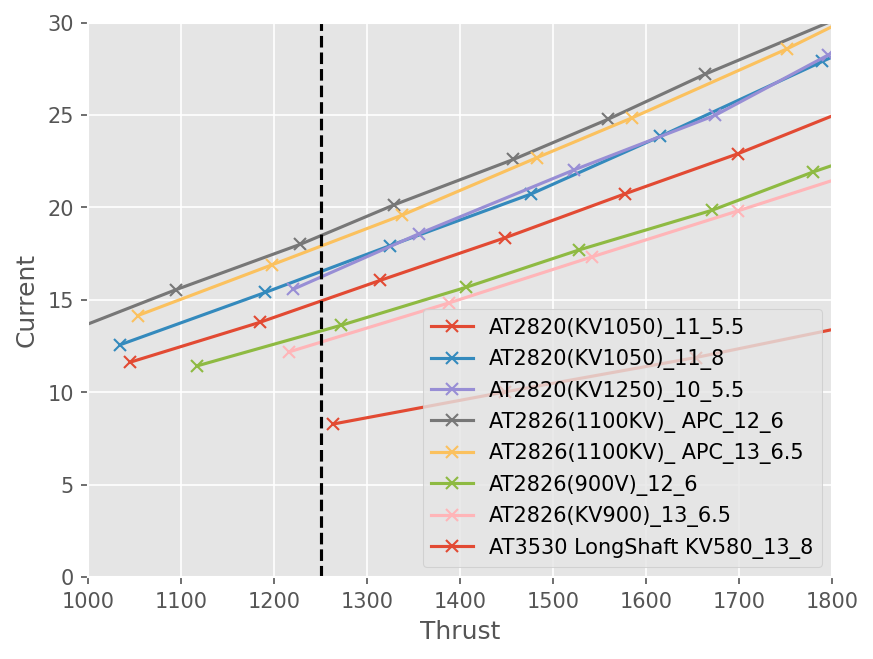

In [10]:
motor_loc = './motors'
motor_names =[]
motor_data = []

Current_RW = []
Current_TR = []
Current_FW = []

# 디렉토리 내 모든 CSV 파일 탐색
for filename in os.listdir(motor_loc):
    if filename.endswith('.xlsx'):
        filepath = os.path.join(motor_loc, filename)    # 파일 디렉토리와 파일명으로부터 불러오기

        # 파일명에서 확장자 제거하고 변수명으로 사용
        var_name = os.path.splitext(filename)[0]

        # CSV 파일 읽기 (헤더 지정)
        df = pd.read_excel(filepath, header=0)
        globals()[var_name] = df
        motor_names.append(var_name)
        motor_data.append(df)

for i, motor in enumerate(motor_data):
    plt.plot(motor['Thrust(g)'], motor['Current(A)'], label = motor_names[i], marker='x')
    Current_RW.append(interpolate(motor['Thrust(g)'], motor['Current(A)'], Thrust_RW))
    Current_FW.append(interpolate(motor['Thrust(g)'], motor['Current(A)'], Thrust_FW))
    Current_TR.append(interpolate(motor['Thrust(g)'], motor['Current(A)'], Thrust_TR))
    

plt.axvline(x=Thrust_RW, linestyle='--', color = 'black')
plt.xlabel('Thrust')
plt.ylabel('Current')
plt.xlim((1000,1800))
plt.ylim((0,30))
plt.legend()
plt.show()

In [11]:
# 여유 마진 30%
margin = 1.3

for i in range(len(motor_names)):
    # 4개 모터에 필요한 총 배터리 양
    mAh = 4*(Current_TR[i]*time_TR + Current_FW[i]*time_FW + Current_RW[i]*time_RW)/3600*1000*margin
    print(motor_names[i],':', mAh,'mAh')


AT2820(KV1050)_11_5.5 : 5157.976683994446 mAh
AT2820(KV1050)_11_8 : 5512.99425922606 mAh
AT2820(KV1250)_10_5.5 : 4452.194977832762 mAh
AT2826(1100KV)_ APC_12_6 : 6353.0023643392815 mAh
AT2826(1100KV)_ APC_13_6.5 : 6120.884420223012 mAh
AT2826(900V)_12_6 : 4544.366074748524 mAh
AT2826(KV900)_13_6.5 : 3926.1168331062377 mAh
AT3530 LongShaft KV580_13_8 : 2625.7780434717697 mAh


In [12]:
for i, motor in enumerate(motor_data):
    print(motor_names[i],':', motor['Voltage(V)'][0], 'V')

AT2820(KV1050)_11_5.5 : 15.1 V
AT2820(KV1050)_11_8 : 15.08 V
AT2820(KV1250)_10_5.5 : 15.0 V
AT2826(1100KV)_ APC_12_6 : 11.28 V
AT2826(1100KV)_ APC_13_6.5 : 11.27 V
AT2826(900V)_12_6 : 15.11 V
AT2826(KV900)_13_6.5 : 15.1 V
AT3530 LongShaft KV580_13_8 : 22.45 V


In [14]:
# 배터리와 변속기 무게(g)
w_battery = 440
w_esc = 84

# 모터4개와 배터리의 무게 합
print('motor & battery & esc weight :',motor_data[6]['Weight(g)'][0]*4 + w_battery + w_esc*4, 'g')

# 프롭 끝단 속도
RPM_tip = interpolate(motor_data[6]['Thrust(g)'], motor_data[6]['RPM'], Thrust_RW)
print('Wing tip speed :',wing_tip_speed(13, RPM_tip),'m/s')


motor & battery & esc weight : 1476 g
Wing tip speed : 196.7607029980256 m/s


## 3. 동체
- 동체의 사이징과 부품 배치


## 4. 착륙장치
- 착륙장치 배치와 타이어 등
- 집게 위치

## 5. 항공기의 공력 특성
- 가로세로 안정성
- PV선도 등
- 천이시 안정성